# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%run functions.py
%run ../../setup_project.py
%run ../../generic_plot_functions.py

import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
# import spikeA
from spikeA.Neuron import Simulated_grid_cell, Simulated_conjunctive_grid_cell, Simulated_HD_Cell
from spikeA.Animal_pose import Animal_pose
from tqdm import tqdm
import pandas as pd
import seaborn as sns
# from spikeA.Neuron import Neuron
import datetime
from statannotations.Annotator import Annotator
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec


In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
import warnings
warnings.filterwarnings('ignore', 
                       message="Passing `palette` without assigning `hue` is deprecated.*",
                       category=FutureWarning)

# Data

In [4]:
onlyOF = myProject.dataPath + "/results/jp451_lstm_firstRF.npy"
lastOF = myProject.dataPath + "/results/jp451_lstm_lastRF.npy"

seed_value = 42
np.random.seed(seed_value)

In [5]:
ROOT_FN = myProject.dataPath + '/results/hd_grid_simulation/'

# Functions

In [6]:
def generateTrainingFileFromSeed(seed):
    np.random.seed(seed)

    grid_param = {}
    grid_param["n_cells"] = 25
    grid_param["orientation"] = np.array([0, np.pi / 3, np.pi / 3 * 2])
    grid_spacing = 35
    grid_param["period"] = np.array(
        [
            grid_spacing * np.cos(np.pi / 6),
            grid_spacing * np.cos(np.pi / 6),
            grid_spacing * np.cos(np.pi / 6),
        ]
    )
    grid_param["offset"] = (
        np.random.rand(grid_param["n_cells"], 2) * grid_param["period"][0]
    )
    peak_rates = np.random.normal(loc=15.0, scale=10.0, size=grid_param["n_cells"])
    peak_rates[peak_rates < 5] = 5
    grid_param["peak_rate"] = peak_rates
    randomHd = np.random.randint(0, 361, size=grid_param["n_cells"])
    grid_param["hd_dir"] = randomHd

    return grid_param

In [7]:
def plotMap(
    ax,
    myMap,
    title="",
    titleY=0.95,
    titleFontSize=10,
    transpose=True,
    cmap="jet",
    vmin=0,
    alpha=1,
):
    """
    Plot one 2D map
    """
    if transpose:
        ax.imshow(
            myMap.T,
            origin="lower",
            cmap=cmap,
            interpolation=None,
            vmin=vmin,
            alpha=alpha,
        )
    else:
        ax.imshow(
            myMap, origin="lower", cmap=cmap, interpolation=None, vmin=vmin, alpha=alpha
        )
    ax.set_title(title, y=titleY, fontsize=titleFontSize)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

In [8]:
grid_param = generateTrainingFileFromSeed(1)

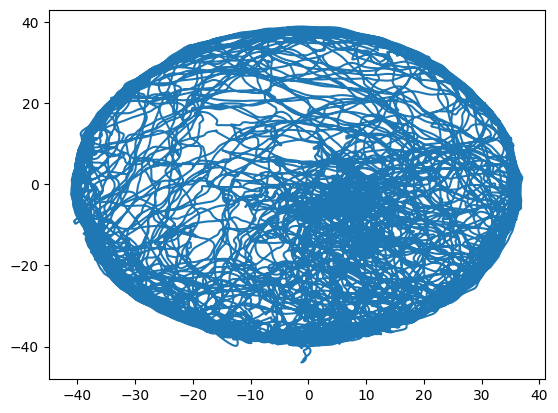

In [9]:
ap = Animal_pose()
ap.load_pose_from_file(file_name=onlyOF)

inter = ap.intervals.inter
ap.set_intervals(inter)


plt.plot(ap.pose[:, 1], ap.pose[:, 2])
plt.show()

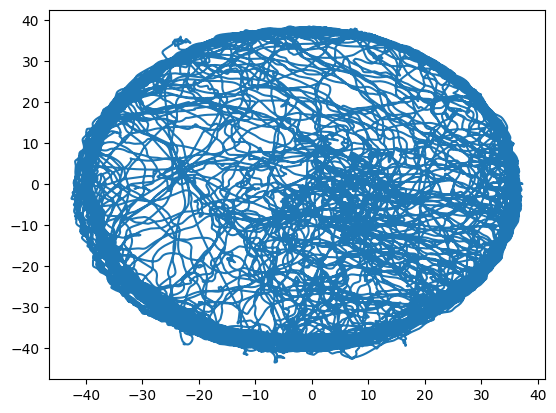

In [10]:
lap = Animal_pose()
lap.load_pose_from_file(file_name=lastOF)

plt.plot(lap.pose[:, 1], lap.pose[:, 2])
plt.show()

In [11]:
conjunctive_hd_neuron_list = [
    Simulated_conjunctive_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=ap,
        peakAngle=grid_param["hd_dir"][i],
        sharpness=5,
        peakRate=20,
        proportionOfGrid=0.02,
    )
    for i in tqdm(range(grid_param["n_cells"]))
]


conjunctive_grid_neuron_list = [
    Simulated_conjunctive_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=ap,
        peakAngle=grid_param["hd_dir"][i],
        sharpness=1,
        peakRate=20,
        proportionOfGrid=0.5,
    )
    for i in tqdm(range(grid_param["n_cells"]))
]

100%|██████████| 25/25 [02:00<00:00,  4.81s/it]


# Plot these neurons

In [12]:
for n in conjunctive_hd_neuron_list:
    n.spatial_properties.firing_rate_map_2d(cm_per_bin=3, smoothing_sigma_cm=5, smoothing=True)
    n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10,smoothing=True)  


In [13]:
for n in conjunctive_grid_neuron_list:
    n.spatial_properties.firing_rate_map_2d(cm_per_bin=3, smoothing_sigma_cm=5, smoothing=True)
    n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10,smoothing=True)  

In [14]:
# Get the HD score of these simulated cells:
hdHolder = []
gridScoreHolder = []
for n in conjunctive_hd_neuron_list:
    hdscore = n.spatial_properties.head_direction_score()[2]
    gridscore = n.spatial_properties.grid_score()
    
    print(f"HD score: {hdscore}, grid score: {gridscore}")
    hdHolder.append(hdscore)
    gridScoreHolder.append(gridscore)
    
hdConDf = pd.DataFrame({'HD':hdHolder,'Grid':gridScoreHolder}) 

HD score: 0.5378906282573281, grid score: 1.2459963792924897
HD score: 0.4848403208131304, grid score: 1.502218169753466
HD score: 0.4832060171443277, grid score: 1.3915397360804034
HD score: 0.5386390932353852, grid score: 1.1811312593504977
HD score: 0.504269306794326, grid score: 1.4187204607703836
HD score: 0.4895196028182363, grid score: 1.3042008959994686
HD score: 0.531126090700959, grid score: 0.9028829188455865
HD score: 0.47679832757536006, grid score: 1.3496859691531597
HD score: 0.5130924579091639, grid score: 1.4478701461495884
HD score: 0.5172511591608966, grid score: 1.3479754750458102
HD score: 0.48367108370232686, grid score: 1.4250953010694114
HD score: 0.43958396242411524, grid score: 1.4534598752279266
HD score: 0.5022280027692149, grid score: 1.5872800625166756
HD score: 0.5196390309283441, grid score: 1.4494455242030866
HD score: 0.5240381379583049, grid score: 1.2169081428507136
HD score: 0.5235907377508201, grid score: 1.2091010580642072
HD score: 0.507072864832

In [15]:
hdConDf['cellType'] = 'conjunctive'

In [16]:
# Get the HD score of these simulated cells:
hdHolder = []
gridScoreHolder = []
for n in conjunctive_grid_neuron_list:
    hdscore = n.spatial_properties.head_direction_score()[2]
    gridscore = n.spatial_properties.grid_score()
    
    print(f"HD score: {hdscore}, grid score: {gridscore}")
    hdHolder.append(hdscore)
    gridScoreHolder.append(gridscore)
    
hdGridDf = pd.DataFrame({'HD':hdHolder,'Grid':gridScoreHolder}) 

HD score: 0.26401857457507544, grid score: 1.3777564270974958
HD score: 0.19536869658924108, grid score: 1.5409904678658912
HD score: 0.2174625633612467, grid score: 1.4664257878842142
HD score: 0.2807041079036414, grid score: 1.265451441034703
HD score: 0.24744025959709337, grid score: 1.4230805817688896
HD score: 0.22482202469955467, grid score: 1.38704452928366
HD score: 0.3152647607243555, grid score: 1.2677102286932769
HD score: 0.22163114909429546, grid score: 1.3488286861660506
HD score: 0.2745037512436101, grid score: 1.4905701796319826
HD score: 0.2626270973631636, grid score: 1.4588495610164425
HD score: 0.18698088344180408, grid score: 1.4449770989331787
HD score: 0.1628339251251517, grid score: 1.5101484829723564
HD score: 0.1707344345433669, grid score: 1.5708111131754796
HD score: 0.26781302508735577, grid score: 1.5255767205523751
HD score: 0.23463046051610406, grid score: 1.3614746858346067
HD score: 0.25859198485573687, grid score: 1.3225418972795775
HD score: 0.225584

In [17]:
hdGridDf['cellType'] = 'grid'

In [18]:
allTogether = pd.concat([hdConDf,hdGridDf])

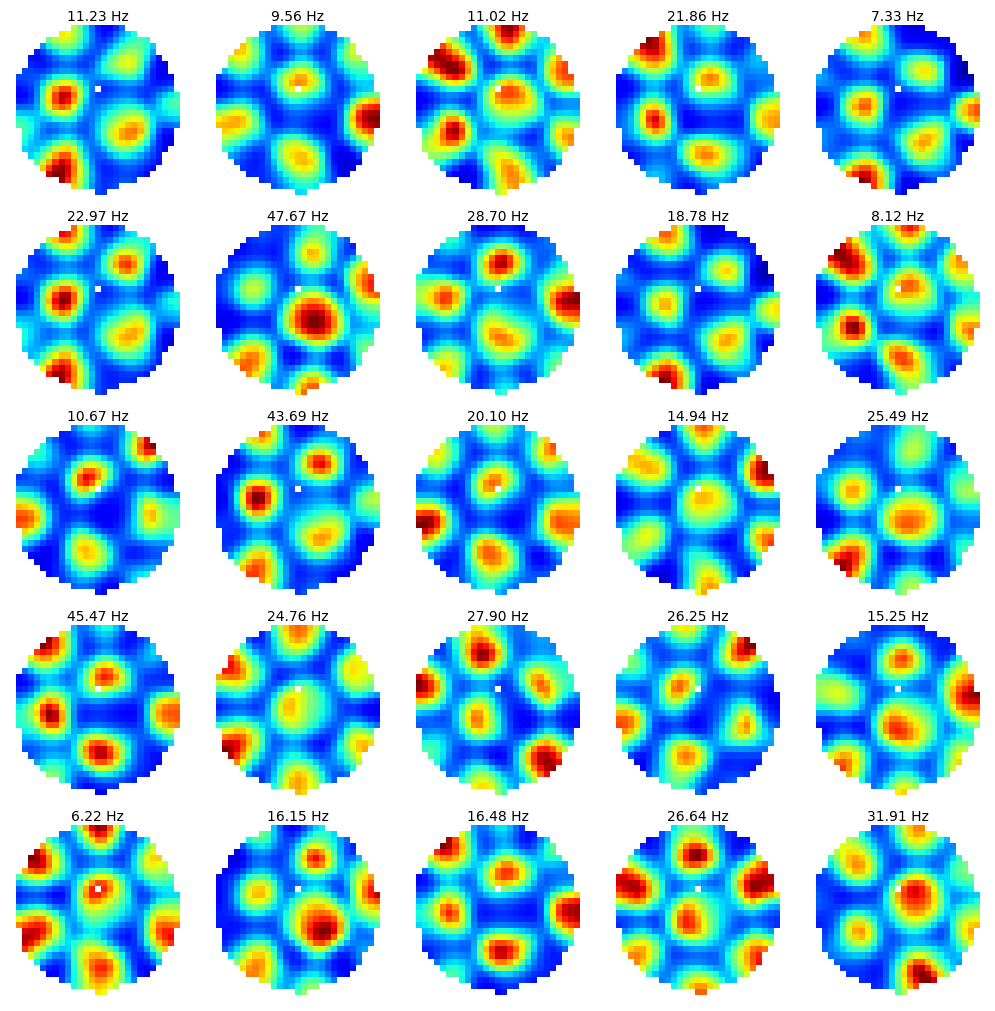

In [19]:
rowSize, colSize = 2, 2
ncols = 5
nrows = int(np.ceil(len(conjunctive_grid_neuron_list) / 5))
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)

maxHolder = []
for i, n in enumerate(conjunctive_grid_neuron_list):
    x = int(i / ncols)
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )
    maxHolder.append(np.nanmax(n.spatial_properties.firing_rate_map))

In [20]:
gridFiring = pd.DataFrame({"max":maxHolder,'type':'grid'})

In [21]:
global_bins = [-3.05432619, -2.87979327, -2.70526034, -2.53072742, -2.35619449,
       -2.18166156, -2.00712864, -1.83259571, -1.65806279, -1.48352986,
       -1.30899694, -1.13446401, -0.95993109, -0.78539816, -0.61086524,
       -0.43633231, -0.26179939, -0.08726646,  0.08726646,  0.26179939,
        0.43633231,  0.61086524,  0.78539816,  0.95993109,  1.13446401,
        1.30899694,  1.48352986,  1.65806279,  1.83259571,  2.00712864,
        2.18166156,  2.35619449,  2.53072742,  2.70526034,  2.87979327,
        3.05432619]

GLOBALFONTSIZE = 11

def plot_hd_map(ax,inputHistos,ylim=20):
    ax.plot(global_bins, inputHistos)
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(0,ylim)
    
    ax.set_xticks([-np.pi,0,np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('Head direction (rad)',fontsize=GLOBALFONTSIZE)

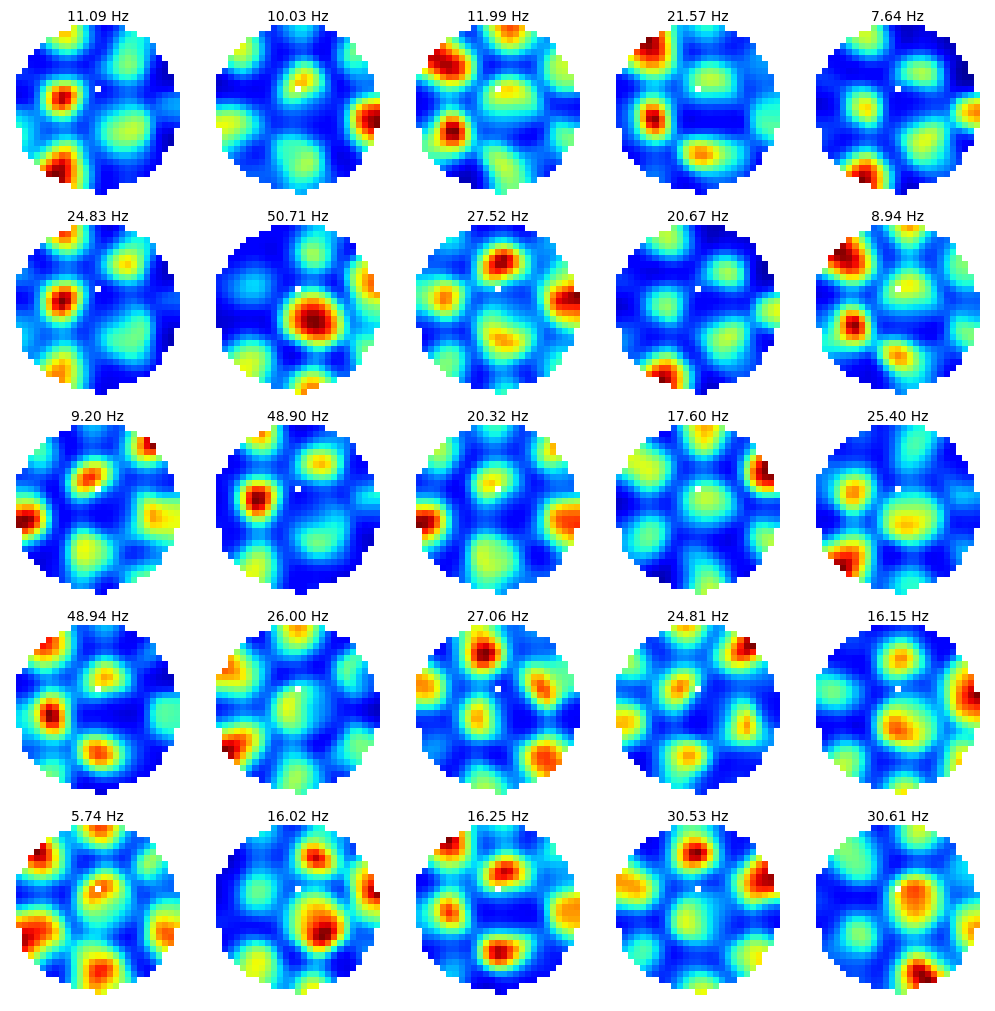

In [22]:
rowSize, colSize = 2, 2
ncols = 5
nrows = int(np.ceil(len(conjunctive_hd_neuron_list) / 5))
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)

maxHolder = []
for i, n in enumerate(conjunctive_hd_neuron_list):
    x = int(i / ncols)
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )
    maxHolder.append(np.nanmax(n.spatial_properties.firing_rate_map))


In [23]:
hdFiring = pd.DataFrame({"max":maxHolder,'type':'hd'})

In [24]:
allFiring = pd.concat([gridFiring,hdFiring])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

grid vs. hd: Mann-Whitney-Wilcoxon test two-sided, P_val:8.462e-01 U_stat=3.020e+02


Text(47.097222222222214, 0.5, 'Peak Firing Rate (Hz)')

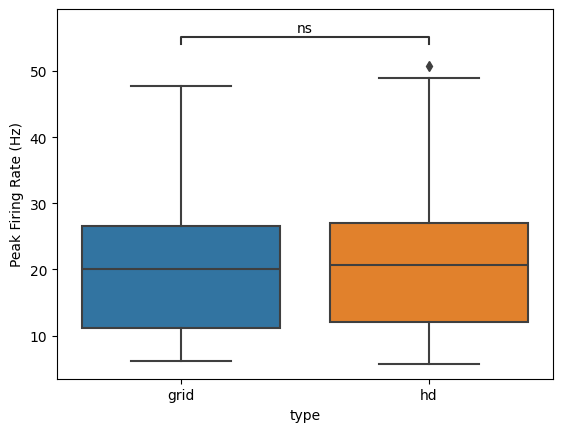

In [25]:
fig, ax =plt.subplots()
b = sns.boxplot(data=allFiring,x='type',y='max')
pairs = [['hd','grid']]
    
annotator = Annotator(
    b,
    pairs,
    data=allFiring,x='type',y='max'
)
    
annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
annotator.apply_and_annotate()
ax.set_ylabel('Peak Firing Rate (Hz)')

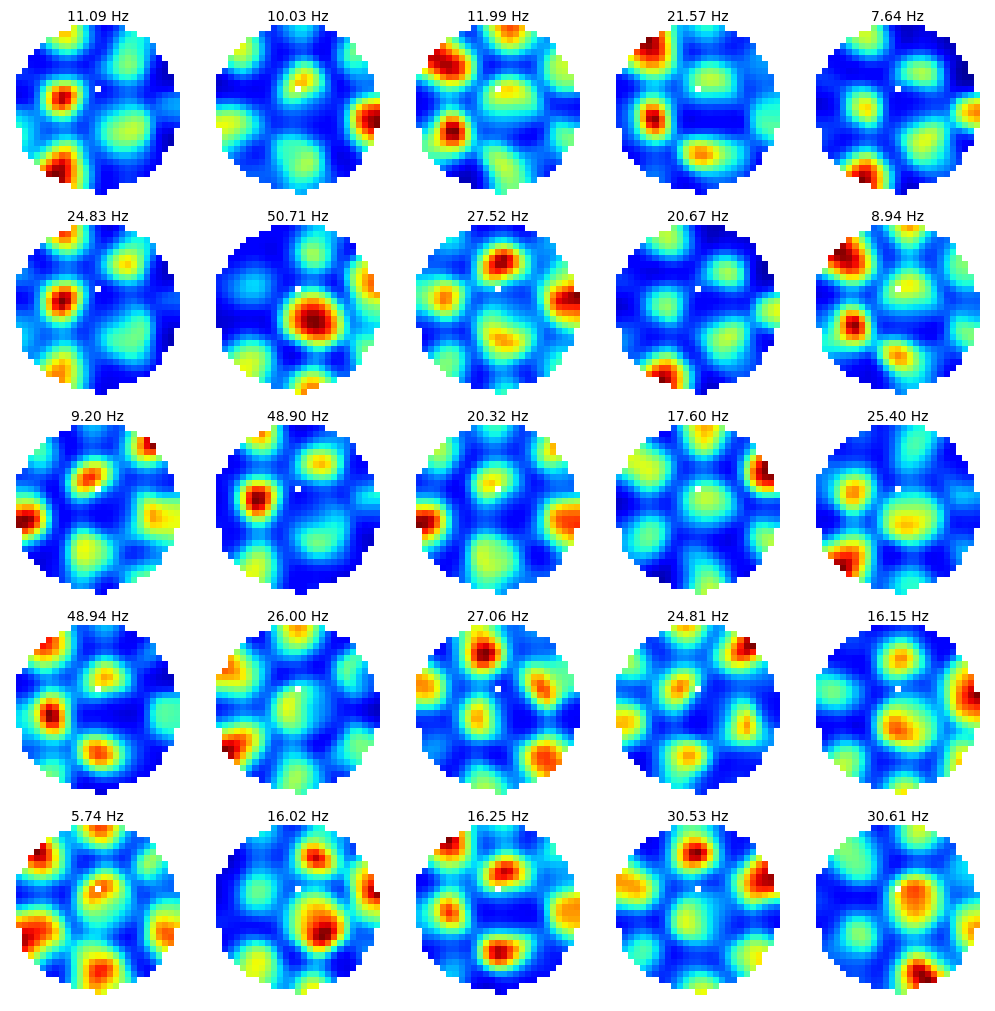

In [26]:
rowSize, colSize = 2, 2
ncols = 5
nrows = int(np.ceil(len(conjunctive_hd_neuron_list) / 5))
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)


for i, n in enumerate(conjunctive_hd_neuron_list):
    x = int(i / ncols)
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High HD
score vs. Low HD
score: Mann-Whitney-Wilcoxon test two-sided, P_val:5.003e-02 U_stat=2.110e+02


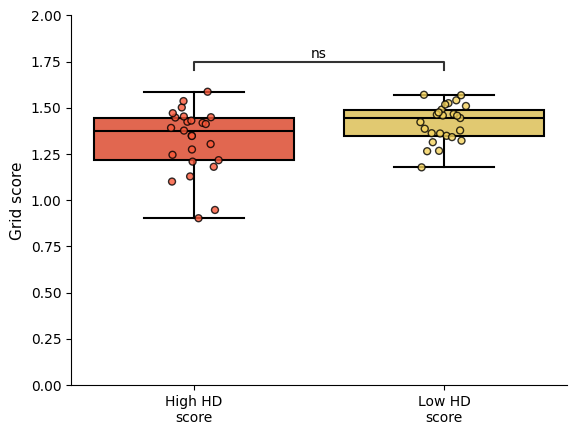

In [27]:
def plot_param_distribution(ax,inputDf,type='Grid',xlabel='',xlim=(0,2)):
    plotDf = inputDf.copy().replace({'conjunctive':'High HD score','grid':'Low HD score'})
    b = sns.histplot(data=plotDf, x =type, hue ='cellType', ax = ax)
    
    ax.set_ylabel('Cell count', fontsize=GLOBALFONTSIZE)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_xlim(xlim)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    sns.move_legend(
        b,
        "lower center",
        bbox_to_anchor=(0.2, 0.8),
        ncol=1,
        title=None,
        frameon=False,
        fontsize=GLOBALFONTSIZE,
    )
    
def plot_param_boxplot(ax,inputDf,type='Grid',ylabel='',ylim=(0,2)):
    pal = ['#f95738','#f4d35e']
    plotDf = inputDf.copy().replace({'conjunctive':'High HD\nscore','grid':'Low HD\nscore'})
    od = plotDf.cellType.unique()
    b = sns.boxplot(data=plotDf, y =type, x ='cellType', ax = ax,showfliers=False,order = od, palette=pal,**boxplot_kwargs)
    sns.stripplot(
        data=plotDf, y =type, x ='cellType',
        edgecolor="black",
        dodge=False,
        palette=pal,
        order = od,
        **stripplot_kwargs,
    )
    
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('')
    ax.set_ylim(ylim)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    pairs = [[od[0],od[1]]]
    
    annotator = Annotator(
        b,
        pairs,
        data=plotDf, y =type, x ='cellType',order = od
    )
    
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()
    

    
    
fig, ax = plt.subplots()
plot_param_boxplot(ax,allTogether,'Grid',ylabel='Grid score')

In [28]:
# Load stats for runs
dfHolder = []
for i in range(10):
    rowResultFn = f'{ROOT_FN}/mvl_results_test_{i}.csv'
    resultDf = pd.read_csv(rowResultFn)
    dfHolder.append(resultDf)

In [29]:
runningResult = pd.concat(dfHolder)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High HD
score vs. Low HD
score: Mann-Whitney-Wilcoxon test two-sided, P_val:5.327e-02 U_stat=2.400e+01


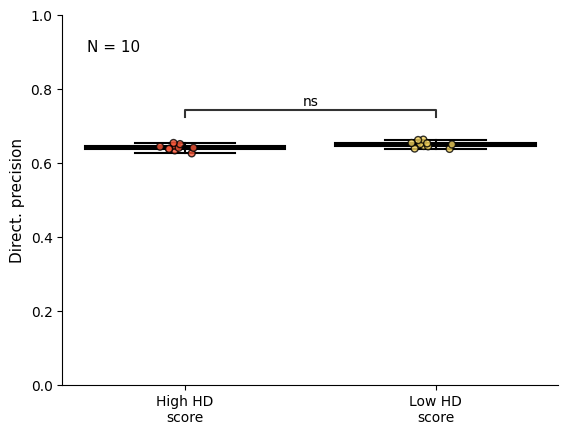

In [30]:
fig, ax =plt.subplots()

def plot_stats_boxplot(ax,inputDf,ylabel='Direct. precision',ylim=(0,1)):
    pal = ['#f95738','#f4d35e']
    plotDf = inputDf.copy().replace({'conjunctive':'High HD\nscore','grid':'Low HD\nscore'})
    od = ['High HD\nscore','Low HD\nscore']
    b = sns.boxplot(data=plotDf, y ='mvl', x ='condition', ax = ax,showfliers=False,order = od, palette=pal,**boxplot_kwargs)
    
    sns.stripplot(
        data=plotDf, y ='mvl', x ='condition',
        edgecolor="black",
        dodge=False,
        palette=pal,
        order = od,
        **stripplot_kwargs,
    )
    
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xlabel('')
    ax.set_ylim(ylim)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    pairs = [[od[0],od[1]]]
    
    annotator = Annotator(
        b,
        pairs, data=plotDf,x ='condition',y ='mvl',order = od
    )
    nNum = plotDf[plotDf.condition == od[0]].shape[0]
    ax.text(0.05, 0.9, f'N = {nNum}', fontsize=GLOBALFONTSIZE,transform = ax.transAxes)
    
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside")
    annotator.apply_and_annotate()
    
plot_stats_boxplot(ax,runningResult)

In [31]:
# Load data from simulations
gridResDf = pd.read_csv(f'{ROOT_FN}/grid_training_result.csv')
conjResDf = pd.read_csv(f'{ROOT_FN}/conj_training_result.csv')

In [32]:
def processDf(inputDf,groupName='grid'):
    inDf = inputDf.dropna(subset=['x','y']).copy()
    mvtDir = np.arctan2(inDf['y'],inDf['x'])
    predMvtDir = np.arctan2(inDf['py'],inDf['px'])
    mvtDirError = np.arctan2(np.cos(mvtDir)*np.sin(predMvtDir)-np.sin(mvtDir)*np.cos(predMvtDir),np.cos(mvtDir)*np.cos(predMvtDir)+np.sin(mvtDir)*np.sin(predMvtDir))
    
    return pd.DataFrame({'mvtDirError':mvtDirError,'condition':groupName})

In [33]:
distributionStatDf = pd.concat([processDf(gridResDf,'grid'),processDf(conjResDf,'conjunctive')]).reset_index(drop=True)

In [34]:
def vl_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.nanmean(np.cos(mvtDirError))
    yMean = np.nanmean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)


def plot_mvt_distribution(ax,inputDf):
    pal = ['#f4d35e','#f95738']
    plotDf = inputDf.copy().replace({'conjunctive':'High HD score','grid':'Low HD score'})
    
    b = sns.histplot(data=plotDf,x='mvtDirError',bins=np.linspace(-np.pi,np.pi,30),hue='condition',palette=pal,ax=ax,stat='density',element='step',common_norm=False,line_kws={'linewidth':2})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Dec. directional error",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Frequency",fontsize=GLOBALFONTSIZE)
    
    ax.set_xlim(-np.pi,np.pi)
    ax.set_xticks([-np.pi,0,np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_ylim(0,0.9)
    
    sns.move_legend(
        b,
        "lower center",
        bbox_to_anchor=(0.5, 0.8),
        ncol=1,
        title=None,
        frameon=False,
        fontsize=GLOBALFONTSIZE,
    )


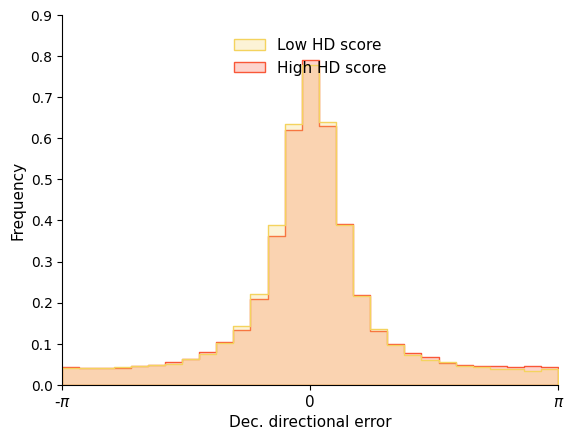

In [35]:
fig, ax =plt.subplots()
plot_mvt_distribution(ax,distributionStatDf)

# Ext_fig_8

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High HD
score vs. Low HD
score: Mann-Whitney-Wilcoxon test two-sided, P_val:5.003e-02 U_stat=2.110e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High HD
score vs. Low HD
score: Mann-Whitney-Wilcoxon test two-sided, P_val:1.416e-09 U_stat=6.250e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High HD
score vs. Low HD
score: Mann-Whitney-Wilcoxon test two-sided, P_val:5.327e-02 U_stat=2.400e+01


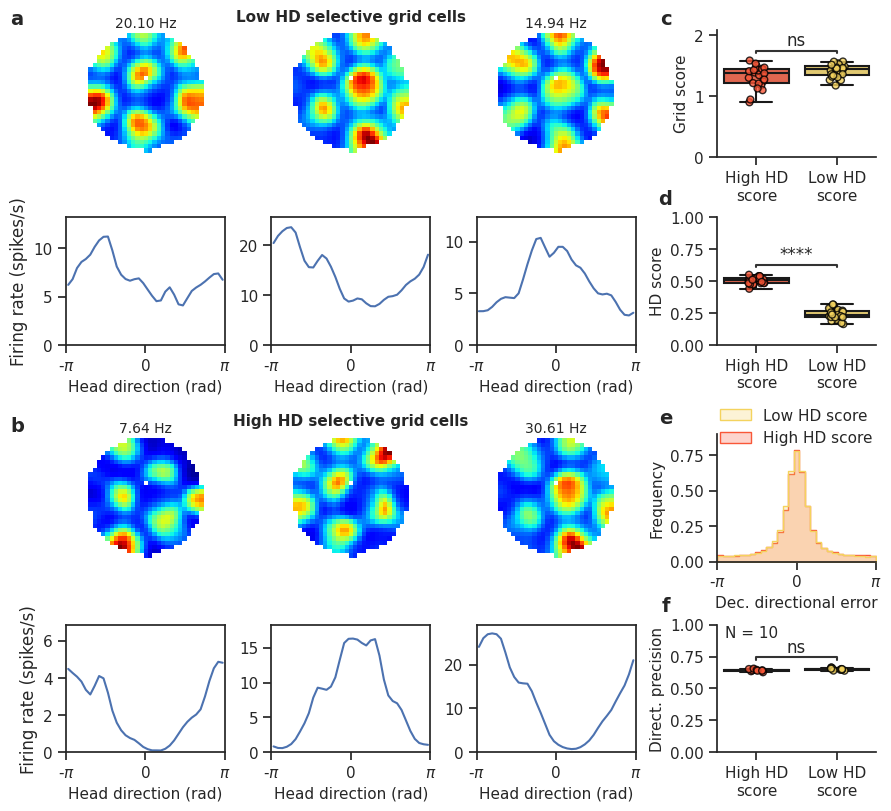

In [37]:
rowSize,colSize= 2,2.2
ncols=4
nrows=4
fig = plt.figure(figsize=(4*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})

#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

import random

random.seed(0)
random_integers = [random.randint(0, 24) for _ in range(3)]

# NOTE Examples
# Plot first row of grid cells from low HD selectivty grid cells
for i, n in enumerate([conjunctive_grid_neuron_list[i] for i in random_integers]):
    ax = fig.add_subplot(gs[0, i])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )
    if i ==1:
        ax.set_title('Low HD selective grid cells',fontsize=GLOBALFONTSIZE,fontweight='bold')
# Plot second row of HD cells from low HD selectivty grid cells   
for i, n in enumerate([conjunctive_grid_neuron_list[i] for i in random_integers]):
    ax = fig.add_subplot(gs[1, i])
    testNeuronHistos = n.spatial_properties.firing_rate_head_direction_histo
    maxValue = np.nanmax(testNeuronHistos) + 2
    plot_hd_map(ax,testNeuronHistos,ylim=maxValue)
    if i == 0:
        ax.set_ylabel('Firing rate (spikes/s)')
    
random.seed(1)
random_integers = [random.randint(0, 24) for _ in range(3)]
    
# NOTE Plot high HD selective conjunctive grid cells
for i, n in enumerate([conjunctive_hd_neuron_list[i] for i in random_integers]):
    ax = fig.add_subplot(gs[2, i])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )
    if i ==1:
        ax.set_title('High HD selective grid cells',fontsize=GLOBALFONTSIZE,fontweight='bold')
# Plot second row of HD cells from low HD selectivty grid cells   
for i, n in enumerate([conjunctive_hd_neuron_list[i] for i in random_integers]):
    ax = fig.add_subplot(gs[3, i])
    testNeuronHistos = n.spatial_properties.firing_rate_head_direction_histo
    maxValue = np.nanmax(testNeuronHistos) + 2
    plot_hd_map(ax,testNeuronHistos,ylim=maxValue)
    if i == 0:
        ax.set_ylabel('Firing rate (spikes/s)')
        
ax = fig.add_subplot(gs[0,3])
plot_param_boxplot(ax,allTogether,'Grid',ylabel='Grid score')

ax = fig.add_subplot(gs[1,3])
plot_param_boxplot(ax,allTogether,'HD',ylabel='HD score',ylim=(0,1))

ax = fig.add_subplot(gs[2,3])
plot_mvt_distribution(ax,distributionStatDf)

# Add the stats for these two groups
ax = fig.add_subplot(gs[3,3])
plot_stats_boxplot(ax,runningResult)



gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0,0.48,'b',fw='900')

add_text(ax0,0.75,1,'c',fw='900')
add_text(ax0,0.75,0.77,'d',fw='900')
add_text(ax0,0.75,0.49,'e',fw='900')
add_text(ax0,0.75,0.25,'f',fw='900')


ax0.axis('off')
####

plt.savefig('../../Output/Ext_Figure8.jpg', bbox_inches='tight', dpi=300)